In [1]:
import pandas as pd
import numpy as np
from scipy import linalg

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
%matplotlib inline

In [4]:
"This cell has the code for generating plot. Do not change."

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')

/var/folders/9x/brj9g4ln5zg0_xwvfm64rgfc0000gq/T/ipykernel_42705/1450426607.py:10: UserWarning: Trying to register the cmap 'red_blue_classes' which already exists.
  plt.cm.register_cmap(cmap=cmap)


In [5]:
# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

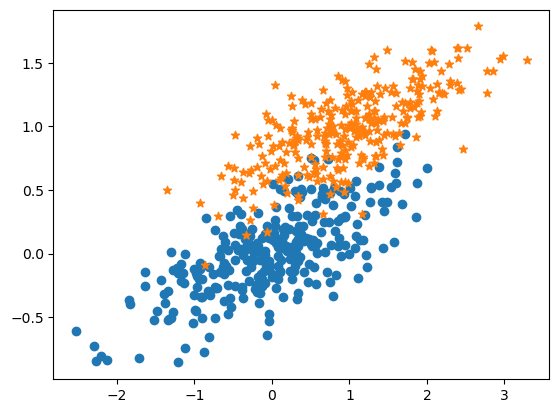

In [6]:
X, y = dataset_fixed_cov()
plt.scatter(X[0:299,0], X[0:299,1], )
plt.scatter(X[300:,0], X[300:,1], marker ='*')
plt.show()

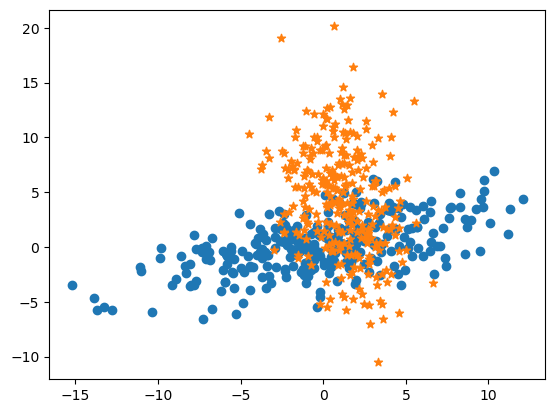

In [7]:
X, y = dataset_cov()
plt.scatter(X[0:299,0], X[0:299,1], )
plt.scatter(X[300:,0], X[300:,1], marker ='*')
plt.show()

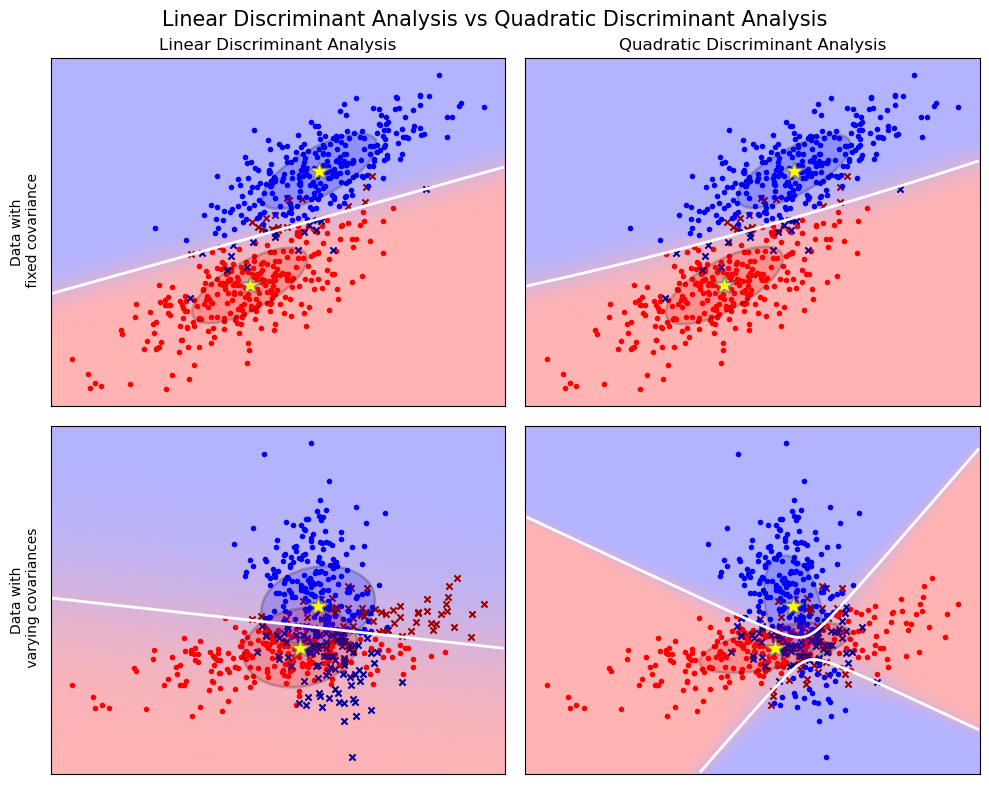

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
plt.figure(figsize=(10, 8), facecolor='white')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis',
             y=0.98, fontsize=15)
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')
    

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Linear Discriminant Analysis

Let's return to the ${\tt Smarket}$ data. 

In [11]:
df = pd.read_csv('Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
df.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


Now we will perform LDA on the ${\tt Smarket}$ data. In ${\tt Python}$, we can fit a LDA model using the ${\tt LDA()}$ function, which is part of the ${\tt lda}$ module of the ${\tt sklearn}$ library. As we did with logistic regression and KNN, we'll fit the model using only the observations before 2005, and then test the model on the data from 2005. We only use `Lag1` and `Lag2` as the features.

In [26]:
X_train = df[:'2004'][['Lag1', 'Lag2']]
y_train = df[:'2004']['Direction']
X_test = df['2005':][['Lag1', 'Lag2']]
y_test = df['2005':]['Direction']

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
LogiRegL1C = LogisticRegression(penalty = 'l1', solver='saga', C=0.1)

In [29]:
LogiRegL1C.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='saga')

In [30]:
pd.Series(LogiRegL1C.coef_[0], index = X_train.columns)

Lag1   -0.028356
Lag2   -0.017249
dtype: float64

In [32]:
X_train = df[:'2004'][['Lag1', 'Lag2']]
y_train = df[:'2004']['Direction']
X_test = df['2005':][['Lag1', 'Lag2']]
y_test = df['2005':]['Direction']

lsa = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [33]:
lda.priors_

array([0.49198397, 0.50801603])

In [34]:
y_train.value_counts()/len(y_train)

Up      0.508016
Down    0.491984
Name: Direction, dtype: float64

In [35]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [36]:
lda.covariance_

array([[ 1.50886781, -0.03340234],
       [-0.03340234,  1.5095363 ]])

The LDA output indicates prior probabilities of ${\hat{\pi}}_1 = 0.492$ and ${\hat{\pi}}_2 = 0.508$; in other words,
49.2% of the training observations correspond to days during which the
market went down.

The above provides the group means in the shapre of (n_classes, n_features); these are the average
of each predictor within each class, and are used by LDA as estimates
of $\mu_k$. These suggest that there is a tendency for the previous 2 days’
returns to be negative on days when the market increases, and a tendency
for the previous days’ returns to be positive on days when the market
declines. 

The ${\tt predict()}$ function returns a list of LDA’s predictions about the movement of the market on the test data:

In [37]:
pred = lda.predict(X_test)

In [38]:
print(np.unique(pred, return_counts = True))

(array(['Down', 'Up'], dtype='<U4'), array([ 70, 182]))


The model assigned 70 observations to the "Down" class, and 182 observations to the "Up" class. Let's check out the confusion matrix to see how this model is doing. We'll want to compare the **predicted class** (which we can find in ${\tt pred}$) to the **true class** (found in ${\tt y\_test})$.

In [39]:
print(confusion_matrix(y_test, pred))

[[ 35  76]
 [ 35 106]]


In [41]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        Down       0.50      0.32      0.39       111
          Up       0.58      0.75      0.66       141

    accuracy                           0.56       252
   macro avg       0.54      0.53      0.52       252
weighted avg       0.55      0.56      0.54       252



We can also get the predicted _probabilities_ using the ${\tt predict\_proba()}$ function:

In [44]:
pred_p = lda.predict_proba(X_test)
pred_p

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234],
       [0.49385615, 0.50614385],
       [0.49510156, 0.50489844],
       [0.4872861 , 0.5127139 ],
       [0.49070135, 0.50929865],
       [0.48440262, 0.51559738],
       [0.49069628, 0.50930372],
       [0.51199885, 0.48800115],
       [0.48951523, 0.51048477],
       [0.47067612, 0.52932388],
       [0.47445929, 0.52554071],
       [0.47995834, 0.52004166],
       [0.49357753, 0.50642247],
       [0.50308938, 0.49691062],
       [0.49788061, 0.50211939],
       [0.48863309, 0.51136691],
       [0.50065681, 0.49934319],
       [0.51087353, 0.48912647],
       [0.50399248, 0.49600752],
       [0.49163351, 0.50836649],
       [0.50417721, 0.49582279],
       [0.50267505, 0.49732495],
       [0.49140429, 0.50859571],
       [0.48059641, 0.51940359],
       [0.48827181, 0.51172819],
       [0.50621869, 0.49378131],
       [0.

Applying a 50% threshold to the posterior probabilities allows us to recreate
the predictions:

In [46]:
print(np.unique(pred_p[:,1]>0.9, return_counts = True))

(array([False]), array([252]))


Notice that the posterior probability output by the model corresponds to
the probability that the market will **increase**:

If we wanted to use a posterior probability threshold other than 50% in
order to make predictions, then we could easily do so. For instance, suppose
that we wish to predict a market decrease only if we are very certain that the
market will indeed decrease on that day—say, if the posterior probability
is at least 90%:

No days in 2005 meet that threshold! In fact, the greatest posterior probability
of decrease in all of 2005 was 54.2%:

# Quadratic Discriminant Analysis
We will now fit a QDA model to the ${\tt Smarket}$ data. QDA is implemented
in ${\tt sklearn}$ using the ${\tt QDA()}$ function, which is part of the ${\tt qda}$ module. The
syntax is identical to that of ${\tt LDA()}$.

In [48]:
qda = QuadraticDiscriminantAnalysis()

In [49]:
qda.fit(X_train, y_train)
pred2 = qda.predict(X_test)

The output contains the group means. But it does not contain the coefficients
of the linear discriminants, because the QDA classifier involves a
_quadratic_, rather than a linear, function of the predictors. The ${\tt predict()}$
function works in exactly the same fashion as for LDA.

In [50]:
pred2 = qda.predict(X_test)

In [51]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

        Down       0.60      0.27      0.37       111
          Up       0.60      0.86      0.71       141

    accuracy                           0.60       252
   macro avg       0.60      0.56      0.54       252
weighted avg       0.60      0.60      0.56       252



Interestingly, the QDA predictions are accurate almost 60% of the time,
even though the 2005 data was not used to fit the model. This level of accuracy
is quite impressive for stock market data, which is known to be quite
hard to model accurately. 

This suggests that the quadratic form assumed
by QDA may capture the true relationship more accurately than the linear
forms assumed by LDA and logistic regression. However, we recommend
evaluating this method’s performance on a larger test set before betting
that this approach will consistently beat the market!

In [54]:
X_train = df[:'2004'][['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
y_train = df[:'2004']['Direction']
X_test = df['2005':][['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
y_test = df['2005':]['Direction']

qda2 = QuadraticDiscriminantAnalysis()
qda2.fit(X_train, y_train)
pred3 = qda2.predict(X_test)
pred3 = qda2.predict(X_test)
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

        Down       0.42      0.74      0.54       111
          Up       0.51      0.21      0.30       141

    accuracy                           0.44       252
   macro avg       0.47      0.48      0.42       252
weighted avg       0.47      0.44      0.41       252



# An Application to Carseats Data
Let's see how the ${\tt LDA/QDA}$ approach performs on the ${\tt Carseats}$ data set. 

Recall: this is a simulated data set containing sales of child car seats at 400 different stores.

In [55]:
df2 = pd.read_csv('Carseats.csv')
df2.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


See if you can build a model that predicts ${\tt ShelveLoc}$, the shelf location (Bad, Good, or Medium) of the product at each store. Don't forget to hold out some of the data for testing! In the train_test_split function, you should use `random_state =1` and `test_size = 0.2`

In [30]:
# Your code here
